In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("almightyj/person-face-sketches")

print("Path to dataset files:", path)
# Path to dataset files: C:\Users\ibrah\.cache\kagglehub\datasets\almightyj\person-face-sketches\versions\2

# CycleGAN for Face Photo-to-Sketch Transformation

This notebook implements a CycleGAN model to transform between face photos and sketches using the Person Face Sketches dataset from Kaggle.

## 1. Import Libraries and Dependencies

First, let's import all necessary libraries and dependencies for our CycleGAN implementation.

In [69]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
from tqdm import tqdm
import kagglehub
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Check for GPU
print("TensorFlow version:", tf.__version__)
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num Physical Devices: ", tf.config.list_physical_devices())

# Define global constants for image dimensions and batch size
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 1  # CycleGAN typically uses small batch sizes

print(f"Using image dimensions: {IMG_HEIGHT}x{IMG_WIDTH} with batch size {BATCH_SIZE}")

TensorFlow version: 2.19.0
GPU Available:  []
Num GPUs Available:  0
Num Physical Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Using image dimensions: 256x256 with batch size 1


## 2. Download and Prepare Dataset

We'll download the "Person Face Sketches" dataset from Kaggle using kagglehub and organize it into two domains: real face photos and sketches.

Path to dataset files: C:\Users\ibrah\.cache\kagglehub\datasets\almightyj\person-face-sketches\versions\2
Train - Photos: 20655, Sketches: 20655
Test - Photos: 679, Sketches: 679
Val - Photos: 1000, Sketches: 1000


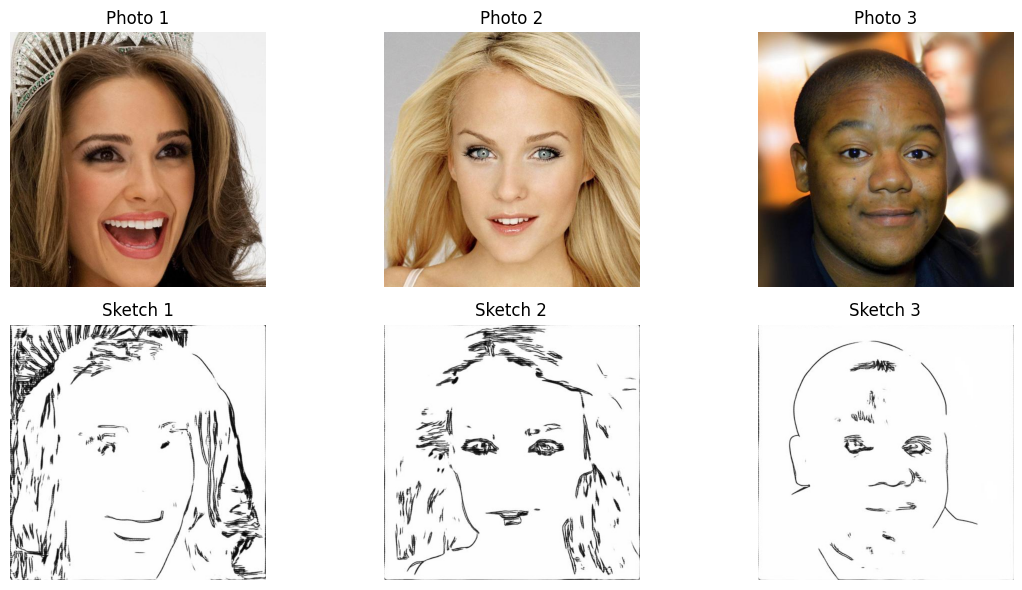

In [11]:
# Update the data directories for the new folder structure
def setup_dataset_paths(base_path):
    """Set up paths for the dataset with train/test/val split"""
    return {
        'train': {
            'photos': os.path.join(base_path, 'train', 'photos'),
            'sketches': os.path.join(base_path, 'train', 'sketches')
        },
        'test': {
            'photos': os.path.join(base_path, 'test', 'photos'),
            'sketches': os.path.join(base_path, 'test', 'sketches')
        },
        'val': {
            'photos': os.path.join(base_path, 'val', 'photos'),
            'sketches': os.path.join(base_path, 'val', 'sketches')
        }
    }

# Download the dataset (if needed) or use a local path
path = kagglehub.dataset_download("almightyj/person-face-sketches")
print("Path to dataset files:", path)

# Set up paths
DATASET_PATH = path
dataset_paths = setup_dataset_paths(DATASET_PATH)

# Verify the dataset structure
for split in ['train', 'test', 'val']:
    photos_path = dataset_paths[split]['photos']
    sketches_path = dataset_paths[split]['sketches']
    
    if os.path.exists(photos_path) and os.path.exists(sketches_path):
        print(f"{split.capitalize()} - Photos: {len(os.listdir(photos_path))}, Sketches: {len(os.listdir(sketches_path))}")
    else:
        print(f"Warning: {split} directory not found or empty")

# Show some example images from training set
plt.figure(figsize=(12, 6))

# Show 3 example photos from training set
train_photos_path = dataset_paths['train']['photos']
for i, file in enumerate(os.listdir(train_photos_path)[:3]):
    plt.subplot(2, 3, i+1)
    img = plt.imread(os.path.join(train_photos_path, file))
    plt.imshow(img)
    plt.title(f"Photo {i+1}")
    plt.axis('off')
    
# Show 3 example sketches from training set
train_sketches_path = dataset_paths['train']['sketches']
for i, file in enumerate(os.listdir(train_sketches_path)[:3]):
    plt.subplot(2, 3, i+4)
    img = plt.imread(os.path.join(train_sketches_path, file))
    plt.imshow(img, cmap='gray')
    plt.title(f"Sketch {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
# Get file paths for each split
def get_file_paths(base_dir):
    """Get all file paths in a directory"""
    return [os.path.join(base_dir, file) for file in os.listdir(base_dir)]

# Get train, test, and validation data
photos_train = get_file_paths(dataset_paths['train']['photos'])
sketches_train = get_file_paths(dataset_paths['train']['sketches'])

photos_test = get_file_paths(dataset_paths['test']['photos'])
sketches_test = get_file_paths(dataset_paths['test']['sketches'])

photos_val = get_file_paths(dataset_paths['val']['photos'])
sketches_val = get_file_paths(dataset_paths['val']['sketches'])

print(f"Training - Photos: {len(photos_train)}, Sketches: {len(sketches_train)}")
print(f"Testing - Photos: {len(photos_test)}, Sketches: {len(sketches_test)}")
print(f"Validation - Photos: {len(photos_val)}, Sketches: {len(sketches_val)}")

Training - Photos: 20655, Sketches: 20655
Testing - Photos: 679, Sketches: 679
Validation - Photos: 1000, Sketches: 1000


## 3. Data Preprocessing and Augmentation

We'll create data generators for preprocessing and augmenting the images. This includes resizing, normalization, and data augmentation.

IMG_HEIGHT: 256, IMG_WIDTH: 256
Preprocessed image shape: (256, 256, 3)
Before jitter shape: Tensor("Shape:0", shape=(3,), dtype=int32)
After jitter shape: Tensor("Shape_1:0", shape=(3,), dtype=int32)
Dataset output batch shape: (1, 256, 256, 3)
Preprocessed image shape: (256, 256, 3)
Before jitter shape: Tensor("Shape:0", shape=(3,), dtype=int32)
After jitter shape: Tensor("Shape_1:0", shape=(3,), dtype=int32)
Dataset output batch shape: (1, 256, 256, 3)
Preprocessed image shape: (256, 256, 3)
Dataset output batch shape: (1, 256, 256, 3)
Preprocessed image shape: (256, 256, 3)
Dataset output batch shape: (1, 256, 256, 3)
Preprocessed image shape: (256, 256, 3)
Dataset output batch shape: (1, 256, 256, 3)
Preprocessed image shape: (256, 256, 3)
Dataset output batch shape: (1, 256, 256, 3)
Sample photo shape: (1, 256, 256, 3)
Sample sketch shape: (1, 256, 256, 3)


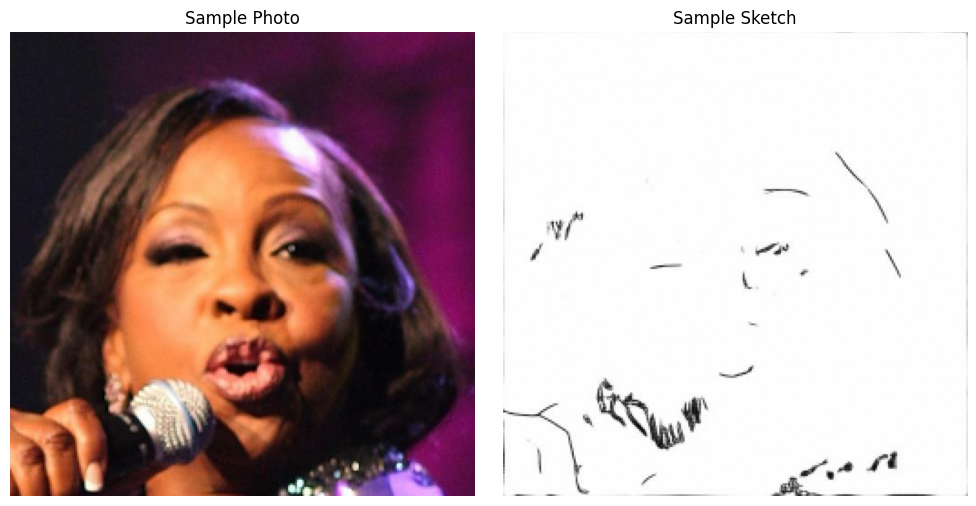

In [70]:
# Define new image preprocessing functions (run this cell first)
def preprocess_image_fixed(image_path):
    """Load and preprocess an image with strict size control"""
    img = tf.io.read_file(image_path)
    
    # Handle both RGB and grayscale images
    try:
        img = tf.io.decode_jpeg(img, channels=3)
    except:
        img = tf.io.decode_png(img, channels=3)
    
    # Explicitly resize to target dimensions
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    
    # Normalize to [-1, 1]
    img = tf.cast(img, tf.float32) / 127.5 - 1
    
    # Debug: Print shape to verify
    print(f"Preprocessed image shape: {img.shape}")
    
    return img

def random_jitter_fixed(image):
    """Apply random jitter with strict size control"""
    # Get current shape (should be [256, 256, 3])
    original_shape = tf.shape(image)
    print(f"Before jitter shape: {original_shape}")
    
    # Resize to larger size for cropping
    image = tf.image.resize(image, [286, 286])
    
    # Random crop to original size
    image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
    
    # Random mirroring
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
    
    # Debug final shape
    final_shape = tf.shape(image)
    print(f"After jitter shape: {final_shape}")
    
    return image

def create_dataset_fixed(image_paths, batch_size, train=True, buffer_size=1000):
    """Create dataset with strict size control"""
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    
    # Use appropriate preprocessing based on train/test
    if train:
        dataset = dataset.map(
            lambda path: random_jitter_fixed(preprocess_image_fixed(path)),
            num_parallel_calls=tf.data.AUTOTUNE
        )
    else:
        dataset = dataset.map(
            preprocess_image_fixed,
            num_parallel_calls=tf.data.AUTOTUNE
        )
    
    # Shuffle if training
    if train:
        dataset = dataset.shuffle(buffer_size)
    
    # Batch and prefetch
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    # Check first batch shape
    for batch in dataset.take(1):
        print(f"Dataset output batch shape: {batch.shape}")
        break
    
    return dataset

# Print constants for verification
print(f"IMG_HEIGHT: {IMG_HEIGHT}, IMG_WIDTH: {IMG_WIDTH}")

# Recreate datasets using the fixed functions
photos_train_dataset = create_dataset_fixed(photos_train, BATCH_SIZE, train=True)
sketches_train_dataset = create_dataset_fixed(sketches_train, BATCH_SIZE, train=True)

# Recreate test and validation datasets
photos_test_dataset = create_dataset_fixed(photos_test, BATCH_SIZE, train=False)
sketches_test_dataset = create_dataset_fixed(sketches_test, BATCH_SIZE, train=False)

photos_val_dataset = create_dataset_fixed(photos_val, BATCH_SIZE, train=False)
sketches_val_dataset = create_dataset_fixed(sketches_val, BATCH_SIZE, train=False)

# Update sample images for visualization
sample_photo = next(iter(photos_val_dataset))
sample_sketch = next(iter(sketches_val_dataset))

# Verify sample shapes
print(f"Sample photo shape: {sample_photo.shape}")
print(f"Sample sketch shape: {sample_sketch.shape}")

# Display samples to verify
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Sample Photo")
plt.imshow((sample_photo[0] * 0.5 + 0.5).numpy())
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Sample Sketch")
plt.imshow((sample_sketch[0] * 0.5 + 0.5).numpy())
plt.axis('off')
plt.tight_layout()
plt.show()

## 4. Create CycleGAN Generator Model

Now, let's implement the Generator model for our CycleGAN. This follows the architecture described in the original paper with an encoder-transformer-decoder structure using residual blocks.

In [79]:
# Add this custom implementation of InstanceNormalization
from tensorflow.keras import layers
import tensorflow as tf

class InstanceNormalization(layers.Layer):
    """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""

    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
        self.scale = None
        self.offset = None

    def build(self, input_shape):
        depth = input_shape[-1]
        self.scale = self.add_weight(
            name='scale',
            shape=[depth],
            initializer=tf.random_normal_initializer(1.0, 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=[depth],
            initializer='zeros',
            trainable=True)

    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset
    

def downsample(filters, size, apply_norm=True):
    """Downsampling layer for the encoder"""
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                           kernel_initializer=initializer, use_bias=False))
    
    if apply_norm:
        result.add(InstanceNormalization())
    
    result.add(layers.LeakyReLU())
    
    return result

def upsample(filters, size, apply_dropout=False):
    """Upsampling layer for the decoder"""
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                     kernel_initializer=initializer, use_bias=False))
    
    result.add(InstanceNormalization())
    
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    
    result.add(layers.ReLU())
    
    return result

def residual_block(filters, size=3):
    """Residual block for the transformer"""
    initializer = tf.random_normal_initializer(0., 0.02)
    
    def block(x):
        y = layers.Conv2D(filters, size, padding='same',
                         kernel_initializer=initializer, use_bias=False)(x)
        y = InstanceNormalization()(y)
        y = layers.ReLU()(y)
        
        y = layers.Conv2D(filters, size, padding='same',
                         kernel_initializer=initializer, use_bias=False)(y)
        y = InstanceNormalization()(y)
        
        return layers.Add()([x, y])
    
    return block

def build_generator_fixed(img_height, img_width, name="generator"):
    """Build the CycleGAN generator model with explicit dimensions"""
    inputs = layers.Input(shape=[img_height, img_width, 3])
    
    print(f"Building generator {name} with input shape {inputs.shape}")
    
    # Encoder (Downsampling)
    x = downsample(64, 7, apply_norm=False)(inputs)  # (batch, 128, 128, 64)
    print(f"After first downsample: {x.shape}")
    
    x = downsample(128, 3)(x)  # (batch, 64, 64, 128)
    print(f"After second downsample: {x.shape}")
    
    x = downsample(256, 3)(x)  # (batch, 32, 32, 256)
    print(f"After third downsample: {x.shape}")
    
    # Transformer (Residual blocks)
    for i in range(9):  # 9 residual blocks
        x = residual_block(256)(x)
    print(f"After residual blocks: {x.shape}")
    
    # Decoder (Upsampling) - must match encoder exactly
    x = upsample(128, 3)(x)  # (batch, 64, 64, 128)
    print(f"After first upsample: {x.shape}")
    
    x = upsample(64, 3)(x)  # (batch, 128, 128, 64)
    print(f"After second upsample: {x.shape}")
    
    # Add one more upsampling layer to get back to 256x256
    x = upsample(32, 3)(x)  # (batch, 256, 256, 32)
    print(f"After third upsample: {x.shape}")
    
    # Final output layer
    x = layers.Conv2D(3, 7, padding='same',
                     kernel_initializer=tf.initializers.RandomNormal(0., 0.02),
                     activation='tanh')(x)  # Final output: (batch, 256, 256, 3)
    print(f"Final output shape: {x.shape}")
    
    return keras.Model(inputs=inputs, outputs=x, name=name)

# Recreate both generators using the fixed architecture
print("\nCreating generators with the fixed architecture...")
generator_G = build_generator_fixed(IMG_HEIGHT, IMG_WIDTH, name="generator_G")  # Sketch to Photo
generator_F = build_generator_fixed(IMG_HEIGHT, IMG_WIDTH, name="generator_F")  # Photo to Sketch
# Print a summary of one of the generators
generator_G.summary()


Creating generators with the fixed architecture...
Building generator generator_G with input shape (None, 256, 256, 3)
After first downsample: (None, 128, 128, 64)
After second downsample: (None, 64, 64, 128)
After third downsample: (None, 32, 32, 256)
After residual blocks: (None, 32, 32, 256)
After first upsample: (None, 64, 64, 128)
After second upsample: (None, 128, 128, 64)
After third upsample: (None, 256, 256, 32)
Final output shape: (None, 256, 256, 3)
Building generator generator_F with input shape (None, 256, 256, 3)
After first downsample: (None, 128, 128, 64)
After second downsample: (None, 64, 64, 128)
After third downsample: (None, 32, 32, 256)
After residual blocks: (None, 32, 32, 256)
After first upsample: (None, 64, 64, 128)
After second upsample: (None, 128, 128, 64)
After third upsample: (None, 256, 256, 32)
Final output shape: (None, 256, 256, 3)


Model: "generator_G"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_60      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_50       │ (None, 128, 128,  │      9,408 │ input_layer_60[0… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_51       │ (None, 64, 64,    │     73,984 │ sequential_50[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_52       │ (None, 32, 32,    │    295,424 │ sequential_51[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_273 (Conv2D) │ (None, 32, 32,    │    589,824 │ sequential_52[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 32, 32,    │        512 │ conv2d_273[0][0]  │
│ (InstanceNormaliza… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_110 (ReLU)    │ (None, 32, 32,    │          0 │ instance_normali… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_274 (Conv2D) │ (None, 32, 32,    │    589,824 │ re_lu_110[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 32, 32,    │        512 │ conv2d_274[0][0]  │
│ (InstanceNormaliza… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_90 (Add)        │ (None, 32, 32,    │          0 │ sequential_52[0]… │
│                     │ 256)              │            │ instance_normali… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_275 (Conv2D) │ (None, 32, 32,    │    589,824 │ add_90[0][0]      │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 32, 32,    │        512 │ conv2d_275[0][0]  │
│ (InstanceNormaliza… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_111 (ReLU)    │ (None, 32, 32,    │          0 │ instance_normali… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_276 (Conv2D) │ (None, 32, 32,    │    589,824 │ re_lu_111[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 32, 32,    │        512 │ conv2d_276[0][0]  │
│ (InstanceNormaliza… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_91 (Add)        │ (None, 32, 32,    │          0 │ add_90[0][0],     │
│                     │ 256)              │            │ instance_normali… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_277 (Conv2D) │ (None, 32, 32,    │    589,824 │ add_91[0][0]    

 Total params: 11,397,091 (43.48 MB)

 Trainable params: 11,397,091 (43.48 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Create CycleGAN Discriminator Model

Next, we'll implement the PatchGAN discriminator which classifies whether image patches are real or fake.

In [80]:
def build_discriminator(img_height, img_width, name="discriminator"):
    """Build the PatchGAN discriminator"""
    initializer = tf.random_normal_initializer(0., 0.02)
    
    inp = layers.Input(shape=[img_height, img_width, 3], name='input_image')
    
    # Layer 1
    x = layers.Conv2D(64, 4, strides=2, padding='same',
                     kernel_initializer=initializer)(inp)
    x = layers.LeakyReLU(0.2)(x)
    
    # Layer 2
    x = layers.Conv2D(128, 4, strides=2, padding='same',
                     kernel_initializer=initializer, use_bias=False)(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    
    # Layer 3
    x = layers.Conv2D(256, 4, strides=2, padding='same',
                     kernel_initializer=initializer, use_bias=False)(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    
    # Layer 4
    x = layers.Conv2D(512, 4, strides=1, padding='same',
                     kernel_initializer=initializer, use_bias=False)(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    
    # Final Layer (Output 1x1 patches)
    x = layers.Conv2D(1, 4, strides=1, padding='same',
                     kernel_initializer=initializer)(x)
    
    return keras.Model(inputs=inp, outputs=x, name=name)

# Create discriminators
discriminator_X = build_discriminator(IMG_HEIGHT, IMG_WIDTH, name="discriminator_X")  # For photos domain
discriminator_Y = build_discriminator(IMG_HEIGHT, IMG_WIDTH, name="discriminator_Y")  # For sketches domain

# Print a summary of one of the discriminators
discriminator_X.summary()

Model: "discriminator_X"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_314 (Conv2D)             │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_76 (LeakyReLU)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_315 (Conv2D)             │ (None, 64, 64, 128)    │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ instance_normalization_296      │ (None, 64, 64, 128)    │           256 │
│ (InstanceNormalization)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_77 (LeakyReLU)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_316 (Conv2D)             │ (None, 32, 32, 256)    │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ instance_normalization_297      │ (None, 32, 32, 256)    │           512 │
│ (InstanceNormalization)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_78 (LeakyReLU)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_317 (Conv2D)             │ (None, 32, 32, 512)    │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ instance_normalization_298      │ (None, 32, 32, 512)    │         1,024 │
│ (InstanceNormalization)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_79 (LeakyReLU)      │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_318 (Conv2D)             │ (None, 32, 32, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,765,633 (10.55 MB)

 Trainable params: 2,765,633 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Define Loss Functions

Now we need to define the various loss functions used in CycleGAN training:
1. Adversarial loss: Makes the generators create realistic images
2. Cycle consistency loss: Ensures the original image can be reconstructed after a full cycle
3. Identity loss: Helps preserve color and content when appropriate

In [81]:
# Define loss functions
def discriminator_loss(real, generated):
    """Discriminator loss - Mean Squared Error as used in the paper"""
    real_loss = tf.keras.losses.MeanSquaredError()(tf.ones_like(real), real)
    generated_loss = tf.keras.losses.MeanSquaredError()(tf.zeros_like(generated), generated)
    total_loss = real_loss + generated_loss
    return total_loss * 0.5

def generator_loss(generated):
    """Generator adversarial loss - MSE as in the paper"""
    return tf.keras.losses.MeanSquaredError()(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image, lambda_value=10):
    """Cycle consistency loss - absolute difference between input and cycled images"""
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return lambda_value * loss

def identity_loss(real_image, same_image, lambda_value=5):
    """Identity loss - penalty when reconstructing an image from the same domain"""
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return lambda_value * 0.5 * loss

# Define optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## 7. Implement Training Loop

Here, we implement the main training loop which handles all the forward/backward passes and model updates.

In [82]:
# Create a checkpoint directory to store the checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_g=generator_G,
                                generator_f=generator_F,
                                discriminator_x=discriminator_X,
                                discriminator_y=discriminator_Y,
                                generator_g_optimizer=generator_g_optimizer,
                                generator_f_optimizer=generator_f_optimizer,
                                discriminator_x_optimizer=discriminator_x_optimizer,
                                discriminator_y_optimizer=discriminator_y_optimizer)

IMG_HEIGHT = 256
IMG_WIDTH = 256

def train_step(real_x, real_y):
    """Training step for CycleGAN with additional size verification"""
    # Print shapes for debugging
    print(f"Inside train_step - X shape: {real_x.shape}, Y shape: {real_y.shape}")
    
    # Force resize if shapes don't match expected dimensions
    if real_x.shape[1:3] != (IMG_HEIGHT, IMG_WIDTH):
        print(f"Resizing X from {real_x.shape[1:3]} to [{IMG_HEIGHT}, {IMG_WIDTH}]")
        real_x = tf.image.resize(real_x, [IMG_HEIGHT, IMG_WIDTH])
        
    if real_y.shape[1:3] != (IMG_HEIGHT, IMG_WIDTH):
        print(f"Resizing Y from {real_y.shape[1:3]} to [{IMG_HEIGHT}, {IMG_WIDTH}]")
        real_y = tf.image.resize(real_y, [IMG_HEIGHT, IMG_WIDTH])
    
    # Final verification
    assert real_x.shape[1] == IMG_HEIGHT and real_x.shape[2] == IMG_WIDTH, f"X shape is {real_x.shape}, expected {[BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 3]}"
    assert real_y.shape[1] == IMG_HEIGHT and real_y.shape[2] == IMG_WIDTH, f"Y shape is {real_y.shape}, expected {[BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 3]}"
    
    # Implement persistent=True to use the gradients more than once
    with tf.GradientTape(persistent=True) as tape:
        # Generator G maps X -> Y
        # Generator F maps Y -> X
        
        # Translate images
        fake_y = generator_G(real_x, training=True)
        cycled_x = generator_F(fake_y, training=True)
        
        fake_x = generator_F(real_y, training=True)
        cycled_y = generator_G(fake_x, training=True)
        
        # Identity mapping for regularization
        same_x = generator_F(real_x, training=True)
        same_y = generator_G(real_y, training=True)
        
        # Discriminator outputs
        disc_real_x = discriminator_X(real_x, training=True)
        disc_real_y = discriminator_Y(real_y, training=True)
        
        disc_fake_x = discriminator_X(fake_x, training=True)
        disc_fake_y = discriminator_Y(fake_y, training=True)
        
        # Calculate losses
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        
        # Cycle consistency losses
        cycle_loss_x = calc_cycle_loss(real_x, cycled_x)
        cycle_loss_y = calc_cycle_loss(real_y, cycled_y)
        total_cycle_loss = cycle_loss_x + cycle_loss_y
        
        # Identity losses
        id_loss_x = identity_loss(real_x, same_x)
        id_loss_y = identity_loss(real_y, same_y)
        total_id_loss = id_loss_x + id_loss_y
        
        # Total generator losses
        total_gen_g_loss = gen_g_loss + total_cycle_loss + total_id_loss
        total_gen_f_loss = gen_f_loss + total_cycle_loss + total_id_loss
        
        # Discriminator losses
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
    
    # Calculate gradients
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_G.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_F.trainable_variables)
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_X.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_Y.trainable_variables)
    
    # Apply gradients
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_G.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_F.trainable_variables))
    
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_X.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_Y.trainable_variables))
    
    return {
        'gen_g_loss': total_gen_g_loss,
        'gen_f_loss': total_gen_f_loss,
        'disc_x_loss': disc_x_loss,
        'disc_y_loss': disc_y_loss
    }

## 8. Generate and Visualize Samples

Let's write functions to generate and visualize sample transformations during training.

In [83]:
def generate_images(model, test_input, save_filename=None):
    """Generate images using the generator model"""
    prediction = model(test_input)
    
    fig = plt.figure(figsize=(12, 6))
    
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Translated Image']
    
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # Convert from [-1, 1] to [0, 1]
        img = (display_list[i] * 0.5 + 0.5).numpy()
        plt.imshow(img)
        plt.axis('off')
    
    if save_filename:
        plt.savefig(save_filename)
    
    plt.show()

# Get a sample image from each domain for visualization
sample_photo = next(iter(photos_test_dataset))
sample_sketch = next(iter(sketches_test_dataset))

# Create output directory for samples
if not os.path.exists('samples'):
    os.makedirs('samples')

In [87]:
def train(photo_dataset, sketch_dataset, epochs, save_checkpoint_every=5):
    """Main training loop with strengthened size checking"""
    # Define progress metrics
    loss_history = {
        'gen_g_loss': [],
        'gen_f_loss': [],
        'disc_x_loss': [],
        'disc_y_loss': []
    }
    
    # Start training
    for epoch in range(epochs):
        start = time.time()
        
        # Initialize epoch metrics
        n = 0
        epoch_losses = {
            'gen_g_loss': 0,
            'gen_f_loss': 0,
            'disc_x_loss': 0,
            'disc_y_loss': 0
        }
        
        # Create a zip of the two datasets
        for image_x, image_y in tqdm(tf.data.Dataset.zip((photo_dataset, sketch_dataset))):
            # Print shapes before passing to train_step
            print(f"Batch {n+1} - X: {image_x.shape}, Y: {image_y.shape}")
            
            # Force resize if needed (extra safety)
            if image_x.shape[1] != IMG_HEIGHT or image_x.shape[2] != IMG_WIDTH:
                image_x = tf.image.resize(image_x, [IMG_HEIGHT, IMG_WIDTH])
                print(f"Resized X to: {image_x.shape}")
                
            if image_y.shape[1] != IMG_HEIGHT or image_y.shape[2] != IMG_WIDTH:
                image_y = tf.image.resize(image_y, [IMG_HEIGHT, IMG_WIDTH])
                print(f"Resized Y to: {image_y.shape}")
            
            # Train on batch
            batch_losses = train_step(image_x, image_y)
            
            # Update metrics
            for loss_name, loss_value in batch_losses.items():
                epoch_losses[loss_name] += loss_value
            
            n += 1
            
            # For debugging, limit to a few batches
            # if n >= 3:
            #     break
        
        # Average losses for the epoch
        for loss_name in epoch_losses:
            epoch_losses[loss_name] /= n
            loss_history[loss_name].append(epoch_losses[loss_name])
        
        # Log the progress
        print(f'Epoch {epoch+1}/{epochs} - Time: {time.time()-start:.2f}s')
        for loss_name, loss_value in epoch_losses.items():
            print(f'\t{loss_name}: {loss_value:.4f}')
        
        # Generate sample images
        if (epoch + 1) % 1 == 0:
            # Generate sketch to photo
            generate_images(generator_G, sample_sketch, 
                         save_filename=f'samples/epoch_{epoch+1}_sketch_to_photo.png')
            
            # Generate photo to sketch
            generate_images(generator_F, sample_photo,
                         save_filename=f'samples/epoch_{epoch+1}_photo_to_sketch.png')
        
        # Save checkpoint
        if (epoch + 1) % save_checkpoint_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
    
    # Save final checkpoint
    checkpoint.save(file_prefix=checkpoint_prefix)
    
    return loss_history

## 9. Save Model Weights

Define function to save model weights and load pre-trained weights for inference.

In [ ]:
def save_models(generator_g, generator_f, discriminator_x, discriminator_y, output_dir="saved_models"):
    """Save all models"""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    generator_g.save(os.path.join(output_dir, "generator_g.keras"))
    generator_f.save(os.path.join(output_dir, "generator_f.keras"))
    discriminator_x.save(os.path.join(output_dir, "discriminator_x.keras"))
    discriminator_y.save(os.path.join(output_dir, "discriminator_y.keras"))

def load_models(output_dir="saved_models"):
    """Load all models"""
    generator_g = keras.models.load_model(os.path.join(output_dir, "generator_g"))
    generator_f = keras.models.load_model(os.path.join(output_dir, "generator_f"))
    discriminator_x = keras.models.load_model(os.path.join(output_dir, "discriminator_x"))
    discriminator_y = keras.models.load_model(os.path.join(output_dir, "discriminator_y"))
    
    return generator_g, generator_f, discriminator_x, discriminator_y

In [89]:
# Run training for a small number of epochs as a demonstration
# Increase EPOCHS for better results (original paper used 200 epochs)
EPOCHS = 50

# Create a smaller dataset for testing
# Remove this limit for full training
# limited_photos_train = photos_train_dataset.take(100)
# limited_sketches_train = sketches_train_dataset.take(100)

print("Starting CycleGAN training...")
# Uncomment the line below to train the model
loss_history = train(photos_train_dataset, sketches_train_dataset, EPOCHS)

# After training, you can save all models
save_models(generator_G, generator_F, discriminator_X, discriminator_Y)

Starting CycleGAN training...


  0%|          | 0/20655 [00:00<?, ?it/s]

Batch 1 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 1/20655 [00:12<71:18:16, 12.43s/it]

Batch 2 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 2/20655 [00:21<58:18:48, 10.16s/it]

Batch 3 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 3/20655 [00:29<52:52:37,  9.22s/it]

Batch 4 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 4/20655 [00:37<50:38:03,  8.83s/it]

Batch 5 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 5/20655 [00:46<50:38:03,  8.83s/it]

Batch 6 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 6/20655 [00:54<50:25:03,  8.79s/it]

Batch 7 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 7/20655 [01:03<50:25:42,  8.79s/it]

Batch 8 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 8/20655 [01:12<51:05:06,  8.91s/it]

Batch 9 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 9/20655 [01:20<49:44:07,  8.67s/it]

Batch 10 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 10/20655 [01:29<48:47:47,  8.51s/it]

Batch 11 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 11/20655 [01:37<49:16:35,  8.59s/it]

Batch 12 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 12/20655 [01:46<49:44:23,  8.67s/it]

Batch 13 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 13/20655 [01:55<49:55:25,  8.71s/it]

Batch 14 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 14/20655 [02:04<50:23:22,  8.79s/it]

Batch 15 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 15/20655 [02:13<51:05:30,  8.91s/it]

Batch 16 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 16/20655 [02:24<53:51:17,  9.39s/it]

Batch 17 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 17/20655 [02:33<53:08:21,  9.27s/it]

Batch 18 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 18/20655 [02:42<52:31:04,  9.16s/it]

Batch 19 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 19/20655 [02:50<51:12:09,  8.93s/it]

Batch 20 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 20/20655 [02:59<50:53:39,  8.88s/it]

Batch 21 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 21/20655 [03:08<51:22:30,  8.96s/it]

Batch 22 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 22/20655 [03:17<52:07:51,  9.10s/it]

Batch 23 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 23/20655 [03:26<51:55:08,  9.06s/it]

Batch 24 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 24/20655 [03:35<50:46:25,  8.86s/it]

Batch 25 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 25/20655 [03:43<50:08:32,  8.75s/it]

Batch 26 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 26/20655 [03:52<50:12:26,  8.76s/it]

Batch 27 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 27/20655 [04:01<50:14:04,  8.77s/it]

Batch 28 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 28/20655 [04:10<50:10:20,  8.76s/it]

Batch 29 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 29/20655 [04:18<49:55:26,  8.71s/it]

Batch 30 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 30/20655 [04:27<49:55:08,  8.71s/it]

Batch 31 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 31/20655 [04:35<48:35:50,  8.48s/it]

Batch 32 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 32/20655 [04:43<47:37:54,  8.31s/it]

Batch 33 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 33/20655 [04:51<46:56:36,  8.19s/it]

Batch 34 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 34/20655 [04:59<46:44:54,  8.16s/it]

Batch 35 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 35/20655 [05:07<46:16:41,  8.08s/it]

Batch 36 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 36/20655 [05:15<46:01:53,  8.04s/it]

Batch 37 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 37/20655 [05:22<45:44:46,  7.99s/it]

Batch 38 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 38/20655 [05:30<45:38:59,  7.97s/it]

Batch 39 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 39/20655 [05:38<45:30:20,  7.95s/it]

Batch 40 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 40/20655 [05:46<45:42:32,  7.98s/it]

Batch 41 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 41/20655 [05:54<45:34:55,  7.96s/it]

Batch 42 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 42/20655 [06:02<45:30:42,  7.95s/it]

Batch 43 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 43/20655 [06:10<45:27:58,  7.94s/it]

Batch 44 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 44/20655 [06:18<45:24:31,  7.93s/it]

Batch 45 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 45/20655 [06:26<45:21:44,  7.92s/it]

Batch 46 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 46/20655 [06:34<46:29:39,  8.12s/it]

Batch 47 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 47/20655 [06:43<47:46:05,  8.34s/it]

Batch 48 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 48/20655 [06:52<47:49:41,  8.36s/it]

Batch 49 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 49/20655 [07:00<48:16:18,  8.43s/it]

Batch 50 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 50/20655 [07:09<49:22:10,  8.63s/it]

Batch 51 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 51/20655 [07:18<49:39:52,  8.68s/it]

Batch 52 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 52/20655 [07:27<49:59:44,  8.74s/it]

Batch 53 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 53/20655 [07:36<50:02:50,  8.75s/it]

Batch 54 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 54/20655 [07:45<50:22:14,  8.80s/it]

Batch 55 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 55/20655 [07:54<50:20:32,  8.80s/it]

Batch 56 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 56/20655 [08:03<50:50:51,  8.89s/it]

Batch 57 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 57/20655 [08:12<51:14:08,  8.95s/it]

Batch 58 - X: (1, 256, 256, 3), Y: (1, 256, 256, 3)
Inside train_step - X shape: (1, 256, 256, 3), Y shape: (1, 256, 256, 3)


  0%|          | 57/20655 [08:19<50:08:29,  8.76s/it]


KeyboardInterrupt: 

## Inference: Testing the Model on New Images

After training, you can use the model to transform your own photos to sketches and vice versa.

In [90]:
def normalize_image(image):
    """Normalize image to [-1, 1] range"""
    # Convert to float32 if not already
    image = tf.cast(image, tf.float32)
    # Normalize to [-1, 1] range
    return (image / 127.5) - 1

def load_and_preprocess_inference_image(image_path):
    """Load and preprocess an image for inference"""
    img = tf.io.read_file(image_path)
    # Handle both RGB and grayscale images
    try:
        img = tf.io.decode_jpeg(img, channels=3)
    except:
        img = tf.io.decode_png(img, channels=3)
    
    # Resize to target dimensions
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = normalize_image(img)
    # Add batch dimension
    img = tf.expand_dims(img, 0)
    return img

def transform_image(model, input_image_path, output_image_path):
    """Transform an image using the generator"""
    input_image = load_and_preprocess_inference_image(input_image_path)
    prediction = model(input_image)
    
    # Convert from [-1, 1] to [0, 1]
    output_image = (prediction[0] * 0.5 + 0.5).numpy()
    
    # Save the output image
    plt.figure(figsize=(10, 10))
    plt.imshow(output_image)
    plt.axis('off')
    plt.savefig(output_image_path, bbox_inches='tight', pad_inches=0)
    plt.close()
    
    return output_image

# Example usage (uncomment after training):
sample_photo_path = os.path.join(photos_test[0])
output_sketch_path = "generated_sketch.jpg"
transform_image(generator_F, sample_photo_path, output_sketch_path)

array([[[0.60918343, 0.49183366, 0.3476631 ],
        [0.48695666, 0.4607795 , 0.3776815 ],
        [0.49981692, 0.3708631 , 0.38454333],
        ...,
        [0.45720717, 0.41555572, 0.35188067],
        [0.3648457 , 0.40749833, 0.47743648],
        [0.5303076 , 0.38481915, 0.4301402 ]],

       [[0.4821496 , 0.45580372, 0.27960765],
        [0.35070235, 0.3408497 , 0.35473222],
        [0.3011122 , 0.39064968, 0.28331238],
        ...,
        [0.1491948 , 0.4319367 , 0.29659337],
        [0.34181434, 0.35039932, 0.28949454],
        [0.29144233, 0.31709367, 0.43350026]],

       [[0.4248759 , 0.4908808 , 0.33947545],
        [0.37933698, 0.2999171 , 0.26675105],
        [0.3841629 , 0.4074228 , 0.31669337],
        ...,
        [0.32731935, 0.42112535, 0.2648952 ],
        [0.3217491 , 0.35942113, 0.31828326],
        [0.3764476 , 0.3309613 , 0.37273178]],

       ...,

       [[0.45744956, 0.42003918, 0.3377077 ],
        [0.50197315, 0.29170355, 0.27763242],
        [0.37144625, 0

## Conclusion

In this notebook, we implemented a CycleGAN model to transform between face photos and sketches using the Person Face Sketches dataset. We covered:

1. Data loading and preprocessing
2. Generator architecture with residual blocks
3. PatchGAN discriminator 
4. Cycle consistency, identity, and adversarial losses
5. Training loop with visualization
6. Model saving and inference

For the best results, train the model for at least 200 epochs as recommended in the original CycleGAN paper.